# OMG Narwhals L1 data processing
## Create NetCDFs from mooring temp logger (sbe56) data

#### This notebook converts L0 data (.cnv) to L1 data (.nc) while incorporating useful metadata into the final data product.

In [1]:
## allows proper loading of external py scripts and functions
%load_ext autoreload
%autoreload 1

In [2]:
## import all necessary libraries
import string
import numpy as np
import pandas as pd
import csv
import glob, os
import matplotlib.pyplot as plt
from pathlib import Path
from pprint import pprint
import xarray as xr
import netCDF4 as nc4

## external, custom py script within same directory
import omg56_funs

## Code used to process a single file

In [7]:
# what year is the data file from? 2018-2019 = '2019' and 2019-2020 = '2020'
year = 2019
# year = 2020

if year == 2019:
    os.chdir("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L0/2019/SBE56")
    metadata_path = Path("/Users/marie/Documents/PhD/Chapter_3/OMG_Python_dir/metadata/2019/SBE56_metadata_2019.csv")
    # output directory
    output_dir = Path('/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L1/2019/SBE56/')
if year == 2020:
    os.chdir("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L0/2020/SBE56")
    metadata_path = Path("/Users/marie/Documents/PhD/Chapter_3/OMG_Python_dir/metadata/2020/SBE56_metadata_2020.csv")
    output_dir = Path('/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L1/2020/SBE56/')

cnvfiles = []
for file in glob.glob("*.cnv"):
    cnvfiles.append(file)
# pprint(cnvfiles)

## get all metadata associated with each data file
# read in csv with metadata
metadata = pd.read_csv(metadata_path)

In [8]:
## enter single cnv filename:
filename = 'SBE05608524_2019-08-05.cnv'

number data lines 1390880
number header lines 88 

* <HardwareData DeviceType='SBE56' SerialNumber='05608524'>
SBE56 05608524
2018-08-24T00:00:00
before
[236.       236.000231 236.000463 236.000694 236.000926]

after
[numpy.datetime64('2018-08-24T00:00:00'),
 numpy.datetime64('2018-08-24T00:00:20'),
 numpy.datetime64('2018-08-24T00:00:40'),
 numpy.datetime64('2018-08-24T00:01:00'),
 numpy.datetime64('2018-08-24T00:01:20')]
recording start time:  2018-08-24T00:00:00
recording end time:  2019-07-11T23:06:20
data successfully trimmed


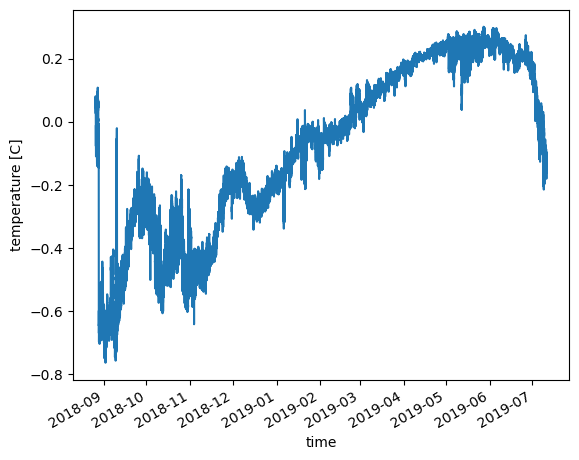

OMG_Narwhals_Mooring_temp_05608524_L1_20180826.nc


<xarray.Dataset>
Dimensions:      (time: 1378080)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-26 ... 2019-07-10T23:59:40
Data variables:
    temperature  (time) float64 0.0631 0.0634 0.0638 ... -0.1561 -0.1567 -0.1567
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0700-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

In [9]:
# process data:

# extract metadata
data = metadata.loc[metadata['filename_L0'] == filename] # select row for cnv file 'filename'
glacier_front = data.glacier_front.values[0]
probe_num = data.probe_num.values[0]
lat = data.lat.values[0]
lon = data.lon.values[0]
bottom_depth = data.bottom_depth.values[0]

if year == 2019:
    file = Path("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L0/2019/SBE56/" + filename) # 2019
if year == 2020:
    file = Path("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L0/2020/SBE56/" + filename) # 2020

uuid = data.uuid.values[0]
depth_target = data.depth_target.values[0]
depth_actual = data.depth_actual.values[0]

## extract data and create dataset
data_lines, device_type, serial_number, start_time_dt64, start_date, sample_interval_plain, sample_interval_td64, var_names = omg56_funs.open_omg_file(file)
mooring_ds = omg56_funs.create_Dataset(data_lines, start_time_dt64, sample_interval_td64, glacier_front, probe_num)

## Create NetCDF variable encoding (required to save the time values properly)
new_encoding = omg56_funs.create_encoding(mooring_ds)

## Save xarray DataSet object as netcdf
# truncate the last measurement times since those are on the deck
# if else statement to truncate data according to each fjord
if year == 2019:
    if glacier_front=='Sverdrup glacier':
        mooring_ds_truncated = mooring_ds.sel(time=slice("2018-08-24","2019-08-02"))
        print('data successfully trimmed')
    elif glacier_front=='Kong Oscar glacier':
        mooring_ds_truncated = mooring_ds.sel(time=slice("2018-08-25","2019-08-03"))
        print('data successfully trimmed')
    elif probe_num == 'PROBE_14':
        mooring_ds_truncated = mooring_ds.sel(time=slice("2018-08-26","2019-07-10"))
        print('data successfully trimmed')
    else: mooring_ds_truncated = mooring_ds.sel(time=slice("2018-08-26","2019-08-04"))
if year == 2020:
    if glacier_front=='Kong Oscar glacier':
        mooring_ds_truncated = mooring_ds.sel(time=slice("2019-08-04T14","2020-08-10T09")) 
        print('data successfully trimmed')
    else: 
        mooring_ds_truncated = mooring_ds.sel(time=slice("2019-08-05T20","2020-08-10T09"))
        print('data successfully trimmed')

# plot trimmed data
mooring_ds_truncated.temperature.plot()
plt.show()

# create netcdf filename:
# “OMG_Narwhals_Mooring_<instrument>_L1_<time_coverage_start>.nc"
date_str = str(mooring_ds_truncated.isel(time=0).time.values)
yymmdd = date_str[0:4] + date_str[5:7] + date_str[8:10]
netcdf_filename = 'OMG_Narwhals_Mooring_temp_L1_' + serial_number + '_' + yymmdd + '.nc'
print(netcdf_filename)

# add metadata
mooring_ds_final = omg56_funs.add_metadata(mooring_ds_truncated, uuid, lat, lon, glacier_front, bottom_depth, depth_target,\
                                           depth_actual, netcdf_filename, start_date, sample_interval_plain, serial_number, device_type, probe_num)

# print dataset
with xr.set_options(display_style="html"):
    display(mooring_ds_final)

# netcdf_filename = Path(netcdf_filename)
mooring_ds_final.to_netcdf(output_dir / netcdf_filename, encoding=new_encoding)
mooring_ds_final.close()

## Code used to process all files within directory

### Process all data in directory

In [3]:
years = [2019, 2020]

number data lines 1494664
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608513'>
SBE56 05608513
2018-08-26T00:00:00
before
[238.       238.000231 238.000463 238.000694 238.000926]

after
[numpy.datetime64('2018-08-26T00:00:00'),
 numpy.datetime64('2018-08-26T00:00:20'),
 numpy.datetime64('2018-08-26T00:00:40'),
 numpy.datetime64('2018-08-26T00:01:00'),
 numpy.datetime64('2018-08-26T00:01:20')]
recording start time:  2018-08-26T00:00:00
recording end time:  2019-08-06T23:41:00
data successfully trimmed


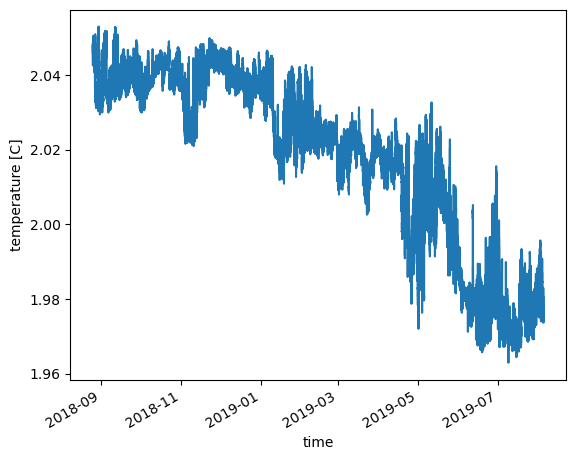

OMG_Narwhals_Mooring_temp_L1_05608513_20180826.nc


<xarray.Dataset>
Dimensions:      (time: 1486080)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-26 ... 2019-08-04T23:59:40
Data variables:
    temperature  (time) float64 2.048 2.047 2.047 2.047 ... 1.976 1.975 1.976
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0d18-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 1492085
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608514'>
SBE56 05608514
2018-08-23T09:00:00
before
[235.375    235.375231 235.375463 235.375694 235.375926]

after
[numpy.datetime64('2018-08-23T09:00:00'),
 numpy.datetime64('2018-08-23T09:00:20'),
 numpy.datetime64('2018-08-23T09:00:40'),
 numpy.datetime64('2018-08-23T09:01:00'),
 numpy.datetime64('2018-08-23T09:01:20')]
recording start time:  2018-08-23T09:00:00
recording end time:  2019-08-03T18:21:20
data successfully trimmed


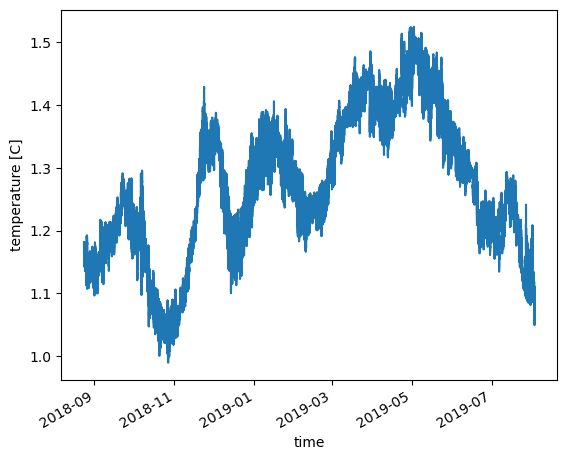

OMG_Narwhals_Mooring_temp_L1_05608514_20180824.nc


<xarray.Dataset>
Dimensions:      (time: 1486080)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-24 ... 2019-08-02T23:59:40
Data variables:
    temperature  (time) float64 1.166 1.165 1.165 1.166 ... 1.103 1.102 1.109
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a00ac-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 1490358
number header lines 88 

* <HardwareData DeviceType='SBE56' SerialNumber='05608515'>
SBE56 05608515
2018-08-26T00:01:13
before
[238.000845 238.001076 238.001308 238.001539 238.001771]

after
[numpy.datetime64('2018-08-26T00:01:13'),
 numpy.datetime64('2018-08-26T00:01:33'),
 numpy.datetime64('2018-08-26T00:01:53'),
 numpy.datetime64('2018-08-26T00:02:13'),
 numpy.datetime64('2018-08-26T00:02:33')]
recording start time:  2018-08-26T00:01:13
recording end time:  2019-08-05T23:46:53
data successfully trimmed


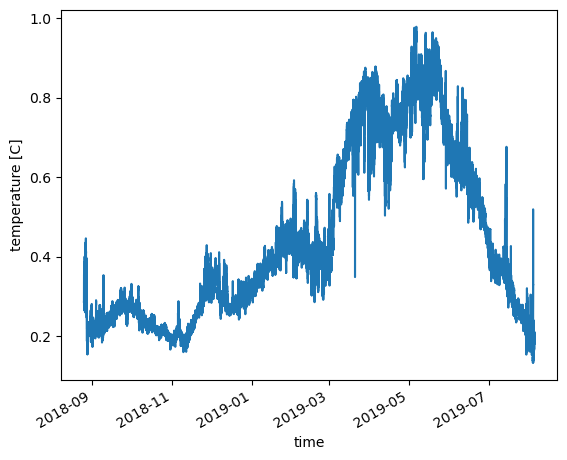

OMG_Narwhals_Mooring_temp_L1_05608515_20180826.nc


<xarray.Dataset>
Dimensions:      (time: 1486077)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-26T00:01:13 ... 2019-08-04T23:...
Data variables:
    temperature  (time) float64 0.2849 0.285 0.2852 ... 0.1927 0.1927 0.1927
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a07b4-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 1490928
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608516'>
SBE56 05608516
2018-08-23T09:00:00
before
[235.375    235.375231 235.375463 235.375694 235.375926]

after
[numpy.datetime64('2018-08-23T09:00:00'),
 numpy.datetime64('2018-08-23T09:00:20'),
 numpy.datetime64('2018-08-23T09:00:40'),
 numpy.datetime64('2018-08-23T09:01:00'),
 numpy.datetime64('2018-08-23T09:01:20')]
recording start time:  2018-08-23T09:00:00
recording end time:  2019-08-03T11:55:40
data successfully trimmed


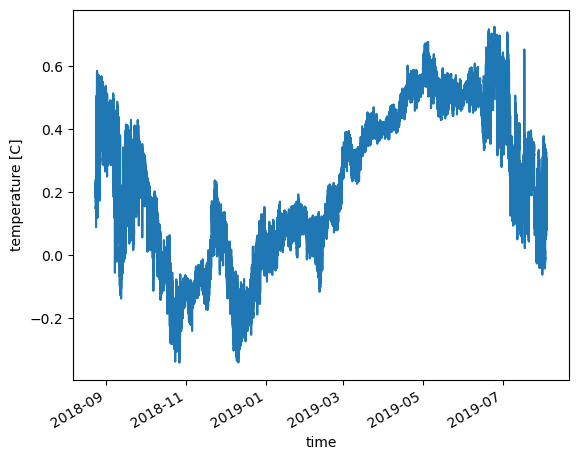

OMG_Narwhals_Mooring_temp_L1_05608516_20180824.nc


<xarray.Dataset>
Dimensions:      (time: 1486080)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-24 ... 2019-08-02T23:59:40
Data variables:
    temperature  (time) float64 0.1518 0.1516 0.1517 ... 0.0984 0.0984 0.0978
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   9069f8c8-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 1494391
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608517'>
SBE56 05608517
2018-08-24T00:00:00
before
[236.       236.000231 236.000463 236.000694 236.000926]

after
[numpy.datetime64('2018-08-24T00:00:00'),
 numpy.datetime64('2018-08-24T00:00:20'),
 numpy.datetime64('2018-08-24T00:00:40'),
 numpy.datetime64('2018-08-24T00:01:00'),
 numpy.datetime64('2018-08-24T00:01:20')]
recording start time:  2018-08-24T00:00:00
recording end time:  2019-08-04T22:10:00
data successfully trimmed


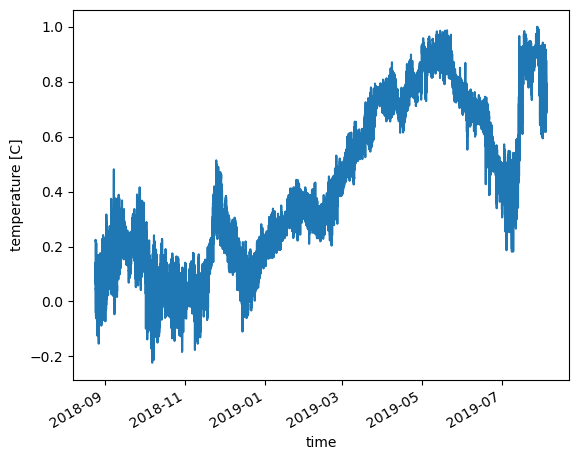

OMG_Narwhals_Mooring_temp_L1_05608517_20180825.nc


<xarray.Dataset>
Dimensions:      (time: 1486080)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-25 ... 2019-08-03T23:59:40
Data variables:
    temperature  (time) float64 0.2206 0.2219 0.2239 ... 0.7632 0.7653 0.7679
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a03f4-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 1491925
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608518'>
SBE56 05608518
2018-08-23T09:00:00
before
[235.375    235.375231 235.375463 235.375694 235.375926]

after
[numpy.datetime64('2018-08-23T09:00:00'),
 numpy.datetime64('2018-08-23T09:00:20'),
 numpy.datetime64('2018-08-23T09:00:40'),
 numpy.datetime64('2018-08-23T09:01:00'),
 numpy.datetime64('2018-08-23T09:01:20')]
recording start time:  2018-08-23T09:00:00
recording end time:  2019-08-03T17:28:00
data successfully trimmed


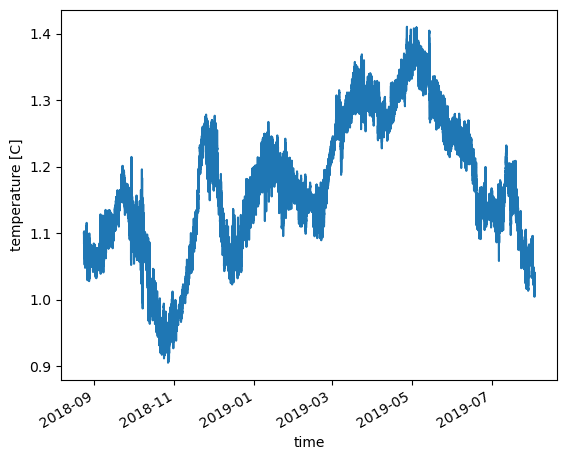

OMG_Narwhals_Mooring_temp_L1_05608518_20180824.nc


<xarray.Dataset>
Dimensions:      (time: 1486080)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-24 ... 2019-08-02T23:59:40
Data variables:
    temperature  (time) float64 1.1 1.101 1.099 1.102 ... 1.035 1.035 1.035
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   9069fef4-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 1494502
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608519'>
SBE56 05608519
2018-08-24T00:00:00
before
[236.       236.000231 236.000463 236.000694 236.000926]

after
[numpy.datetime64('2018-08-24T00:00:00'),
 numpy.datetime64('2018-08-24T00:00:20'),
 numpy.datetime64('2018-08-24T00:00:40'),
 numpy.datetime64('2018-08-24T00:01:00'),
 numpy.datetime64('2018-08-24T00:01:20')]
recording start time:  2018-08-24T00:00:00
recording end time:  2019-08-04T22:47:00
data successfully trimmed


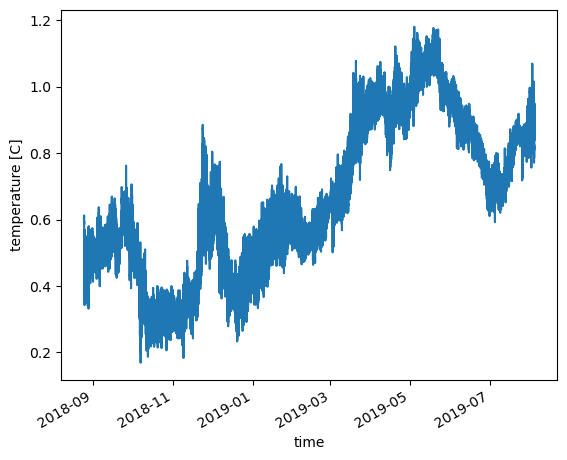

OMG_Narwhals_Mooring_temp_L1_05608519_20180825.nc


<xarray.Dataset>
Dimensions:      (time: 1486080)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-25 ... 2019-08-03T23:59:40
Data variables:
    temperature  (time) float64 0.6037 0.6035 0.6083 ... 0.8897 0.8891 0.8892
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0642-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 1491304
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608520'>
SBE56 05608520
2018-08-23T09:00:00
before
[235.375    235.375231 235.375463 235.375694 235.375926]

after
[numpy.datetime64('2018-08-23T09:00:00'),
 numpy.datetime64('2018-08-23T09:00:20'),
 numpy.datetime64('2018-08-23T09:00:40'),
 numpy.datetime64('2018-08-23T09:01:00'),
 numpy.datetime64('2018-08-23T09:01:20')]
recording start time:  2018-08-23T09:00:00
recording end time:  2019-08-03T14:01:00
data successfully trimmed


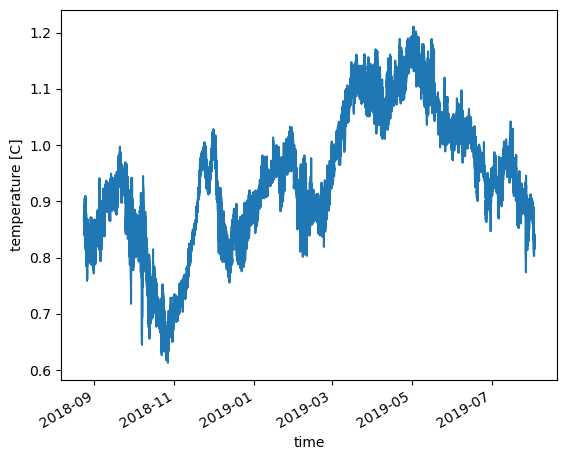

OMG_Narwhals_Mooring_temp_L1_05608520_20180824.nc


<xarray.Dataset>
Dimensions:      (time: 1486080)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-24 ... 2019-08-02T23:59:40
Data variables:
    temperature  (time) float64 0.8684 0.869 0.8693 ... 0.8305 0.8305 0.8306
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   9069fb66-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 1494441
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608521'>
SBE56 05608521
2018-08-26T00:00:00
before
[238.       238.000231 238.000463 238.000694 238.000926]

after
[numpy.datetime64('2018-08-26T00:00:00'),
 numpy.datetime64('2018-08-26T00:00:20'),
 numpy.datetime64('2018-08-26T00:00:40'),
 numpy.datetime64('2018-08-26T00:01:00'),
 numpy.datetime64('2018-08-26T00:01:20')]
recording start time:  2018-08-26T00:00:00
recording end time:  2019-08-06T22:26:40
data successfully trimmed


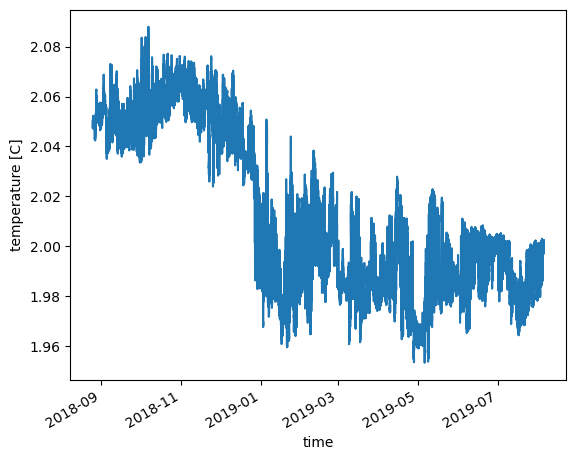

OMG_Narwhals_Mooring_temp_L1_05608521_20180826.nc


<xarray.Dataset>
Dimensions:      (time: 1486080)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-26 ... 2019-08-04T23:59:40
Data variables:
    temperature  (time) float64 2.048 2.048 2.048 2.048 ... 2.002 2.002 2.002
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0b2e-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 1490445
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608522'>
SBE56 05608522
2018-08-26T00:00:00
before
[238.       238.000231 238.000463 238.000694 238.000926]

after
[numpy.datetime64('2018-08-26T00:00:00'),
 numpy.datetime64('2018-08-26T00:00:20'),
 numpy.datetime64('2018-08-26T00:00:40'),
 numpy.datetime64('2018-08-26T00:01:00'),
 numpy.datetime64('2018-08-26T00:01:20')]
recording start time:  2018-08-26T00:00:00
recording end time:  2019-08-06T00:14:40
data successfully trimmed


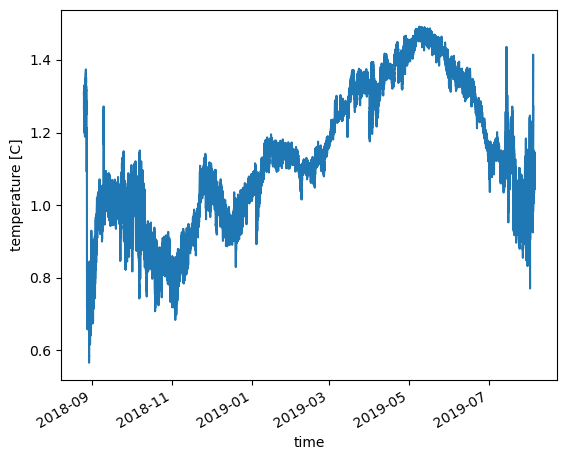

OMG_Narwhals_Mooring_temp_L1_05608522_20180826.nc


<xarray.Dataset>
Dimensions:      (time: 1486080)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-26 ... 2019-08-04T23:59:40
Data variables:
    temperature  (time) float64 1.305 1.306 1.306 1.306 ... 1.129 1.133 1.133
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0868-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 1491201
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608523'>
SBE56 05608523
2018-08-23T09:00:00
before
[235.375    235.375231 235.375463 235.375694 235.375926]

after
[numpy.datetime64('2018-08-23T09:00:00'),
 numpy.datetime64('2018-08-23T09:00:20'),
 numpy.datetime64('2018-08-23T09:00:40'),
 numpy.datetime64('2018-08-23T09:01:00'),
 numpy.datetime64('2018-08-23T09:01:20')]
recording start time:  2018-08-23T09:00:00
recording end time:  2019-08-03T13:26:40
data successfully trimmed


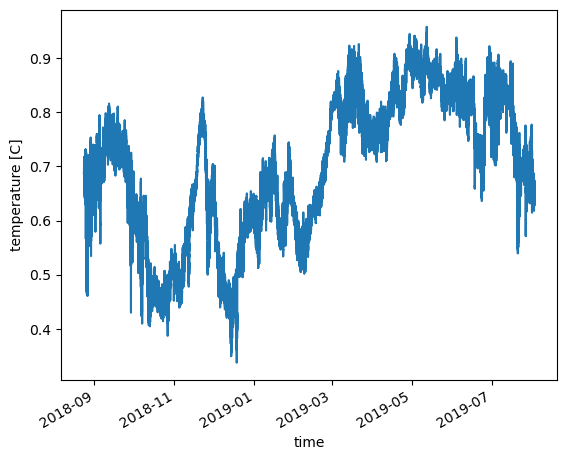

OMG_Narwhals_Mooring_temp_L1_05608523_20180824.nc


<xarray.Dataset>
Dimensions:      (time: 1486080)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-24 ... 2019-08-02T23:59:40
Data variables:
    temperature  (time) float64 0.6889 0.6879 0.6871 ... 0.6523 0.6522 0.6518
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   9069faa8-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 1390880
number header lines 88 

* <HardwareData DeviceType='SBE56' SerialNumber='05608524'>
SBE56 05608524
2018-08-24T00:00:00
before
[236.       236.000231 236.000463 236.000694 236.000926]

after
[numpy.datetime64('2018-08-24T00:00:00'),
 numpy.datetime64('2018-08-24T00:00:20'),
 numpy.datetime64('2018-08-24T00:00:40'),
 numpy.datetime64('2018-08-24T00:01:00'),
 numpy.datetime64('2018-08-24T00:01:20')]
recording start time:  2018-08-24T00:00:00
recording end time:  2019-07-11T23:06:20
data successfully trimmed


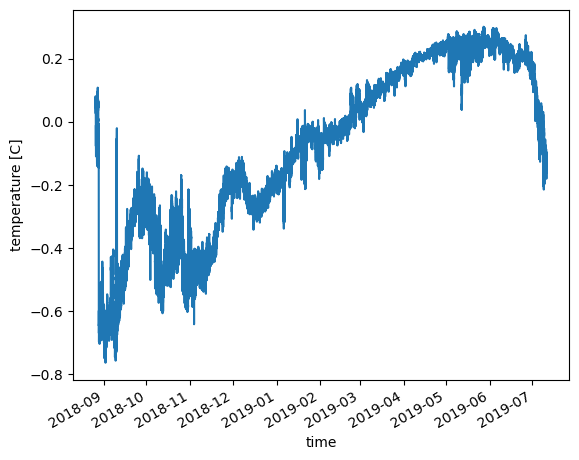

OMG_Narwhals_Mooring_temp_L1_05608524_20180826.nc


<xarray.Dataset>
Dimensions:      (time: 1378080)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-26 ... 2019-07-10T23:59:40
Data variables:
    temperature  (time) float64 0.0631 0.0634 0.0638 ... -0.1561 -0.1567 -0.1567
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0700-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 1492015
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608525'>
SBE56 05608525
2018-08-23T09:00:00
before
[235.375    235.375231 235.375463 235.375694 235.375926]

after
[numpy.datetime64('2018-08-23T09:00:00'),
 numpy.datetime64('2018-08-23T09:00:20'),
 numpy.datetime64('2018-08-23T09:00:40'),
 numpy.datetime64('2018-08-23T09:01:00'),
 numpy.datetime64('2018-08-23T09:01:20')]
recording start time:  2018-08-23T09:00:00
recording end time:  2019-08-03T17:58:00
data successfully trimmed


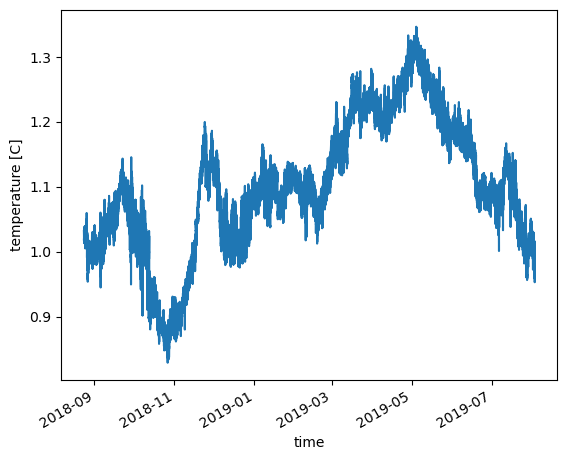

OMG_Narwhals_Mooring_temp_L1_05608525_20180824.nc


<xarray.Dataset>
Dimensions:      (time: 1486080)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-24 ... 2019-08-02T23:59:40
Data variables:
    temperature  (time) float64 1.019 1.018 1.017 1.018 ... 0.978 0.9786 0.9782
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   9069fc88-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 1494281
number header lines 88 

* <HardwareData DeviceType='SBE56' SerialNumber='05608526'>
SBE56 05608526
2018-08-24T00:00:00
before
[236.       236.000231 236.000463 236.000694 236.000926]

after
[numpy.datetime64('2018-08-24T00:00:00'),
 numpy.datetime64('2018-08-24T00:00:20'),
 numpy.datetime64('2018-08-24T00:00:40'),
 numpy.datetime64('2018-08-24T00:01:00'),
 numpy.datetime64('2018-08-24T00:01:20')]
recording start time:  2018-08-24T00:00:00
recording end time:  2019-08-04T21:33:20
data successfully trimmed


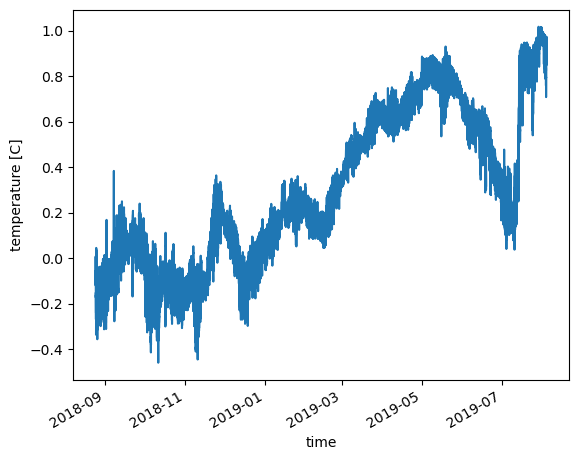

OMG_Narwhals_Mooring_temp_L1_05608526_20180825.nc


<xarray.Dataset>
Dimensions:      (time: 1486080)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-25 ... 2019-08-03T23:59:40
Data variables:
    temperature  (time) float64 -0.0583 -0.0586 -0.0553 ... 0.8878 0.8895 0.8872
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0336-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 1490586
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608527'>
SBE56 05608527
2018-08-26T00:00:00
before
[238.       238.000231 238.000463 238.000694 238.000926]

after
[numpy.datetime64('2018-08-26T00:00:00'),
 numpy.datetime64('2018-08-26T00:00:20'),
 numpy.datetime64('2018-08-26T00:00:40'),
 numpy.datetime64('2018-08-26T00:01:00'),
 numpy.datetime64('2018-08-26T00:01:20')]
recording start time:  2018-08-26T00:00:00
recording end time:  2019-08-06T01:01:40
data successfully trimmed


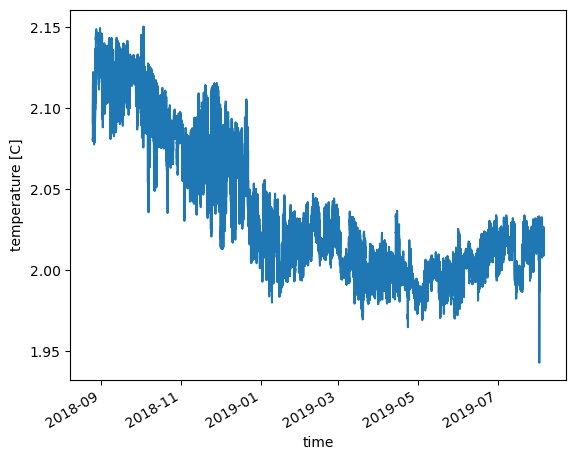

OMG_Narwhals_Mooring_temp_L1_05608527_20180826.nc


<xarray.Dataset>
Dimensions:      (time: 1486080)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-26 ... 2019-08-04T23:59:40
Data variables:
    temperature  (time) float64 2.081 2.081 2.081 2.081 ... 2.019 2.019 2.019
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0a70-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 1494725
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608528'>
SBE56 05608528
2018-08-26T00:00:00
before
[238.       238.000231 238.000463 238.000694 238.000926]

after
[numpy.datetime64('2018-08-26T00:00:00'),
 numpy.datetime64('2018-08-26T00:00:20'),
 numpy.datetime64('2018-08-26T00:00:40'),
 numpy.datetime64('2018-08-26T00:01:00'),
 numpy.datetime64('2018-08-26T00:01:20')]
recording start time:  2018-08-26T00:00:00
recording end time:  2019-08-07T00:01:20
data successfully trimmed


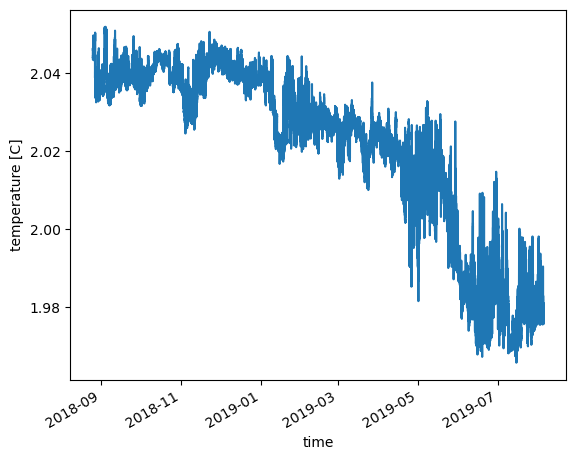

OMG_Narwhals_Mooring_temp_L1_05608528_20180826.nc


<xarray.Dataset>
Dimensions:      (time: 1486080)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-26 ... 2019-08-04T23:59:40
Data variables:
    temperature  (time) float64 2.046 2.046 2.046 2.046 ... 1.98 1.98 1.981 1.98
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0e94-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 1491116
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608529'>
SBE56 05608529
2018-08-23T09:00:00
before
[235.375    235.375231 235.375463 235.375694 235.375926]

after
[numpy.datetime64('2018-08-23T09:00:00'),
 numpy.datetime64('2018-08-23T09:00:20'),
 numpy.datetime64('2018-08-23T09:00:40'),
 numpy.datetime64('2018-08-23T09:01:00'),
 numpy.datetime64('2018-08-23T09:01:20')]
recording start time:  2018-08-23T09:00:00
recording end time:  2019-08-03T12:58:20
data successfully trimmed


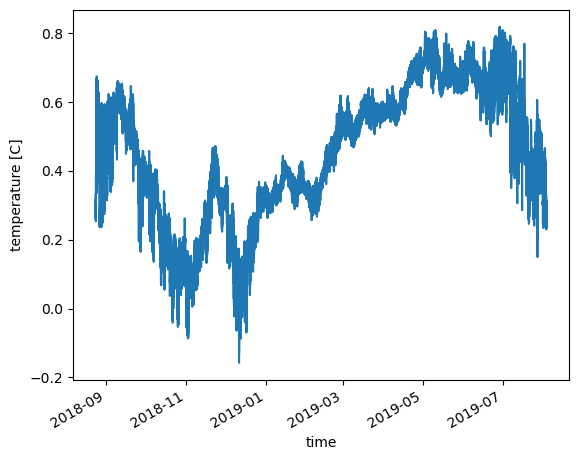

OMG_Narwhals_Mooring_temp_L1_05608529_20180824.nc


<xarray.Dataset>
Dimensions:      (time: 1486080)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-24 ... 2019-08-02T23:59:40
Data variables:
    temperature  (time) float64 0.2763 0.2763 0.2758 ... 0.277 0.2784 0.2802
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   9069f97c-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 1493968
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608530'>
SBE56 05608530
2018-08-24T00:00:00
before
[236.       236.000231 236.000463 236.000694 236.000926]

after
[numpy.datetime64('2018-08-24T00:00:00'),
 numpy.datetime64('2018-08-24T00:00:20'),
 numpy.datetime64('2018-08-24T00:00:40'),
 numpy.datetime64('2018-08-24T00:01:00'),
 numpy.datetime64('2018-08-24T00:01:20')]
recording start time:  2018-08-24T00:00:00
recording end time:  2019-08-04T19:49:00
data successfully trimmed


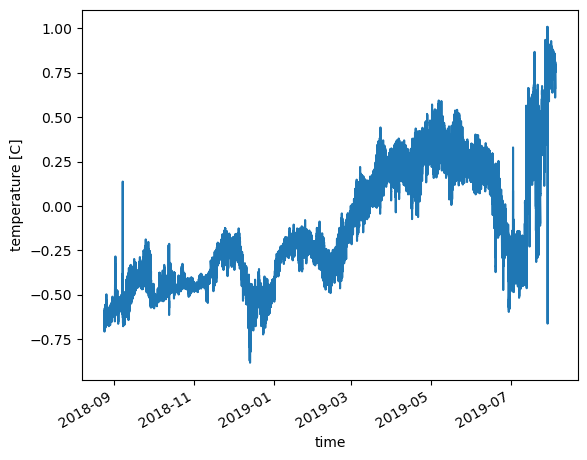

OMG_Narwhals_Mooring_temp_L1_05608530_20180825.nc


<xarray.Dataset>
Dimensions:      (time: 1486080)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-25 ... 2019-08-03T23:59:40
Data variables:
    temperature  (time) float64 -0.6164 -0.6146 -0.6139 ... 0.7776 0.7777 0.7782
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0160-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 1494035
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608532'>
SBE56 05608532
2018-08-24T00:00:00
before
[236.       236.000231 236.000463 236.000694 236.000926]

after
[numpy.datetime64('2018-08-24T00:00:00'),
 numpy.datetime64('2018-08-24T00:00:20'),
 numpy.datetime64('2018-08-24T00:00:40'),
 numpy.datetime64('2018-08-24T00:01:00'),
 numpy.datetime64('2018-08-24T00:01:20')]
recording start time:  2018-08-24T00:00:00
recording end time:  2019-08-04T20:11:20
data successfully trimmed


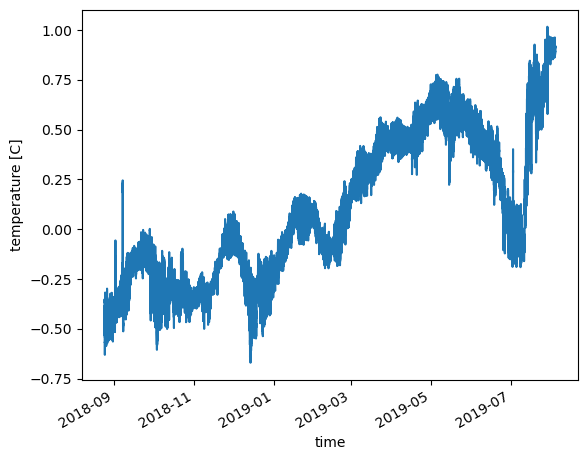

OMG_Narwhals_Mooring_temp_L1_05608532_20180825.nc


<xarray.Dataset>
Dimensions:      (time: 1486080)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-25 ... 2019-08-03T23:59:40
Data variables:
    temperature  (time) float64 -0.3662 -0.3658 -0.3636 ... 0.9097 0.9096 0.9101
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0214-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 1490488
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608533'>
SBE56 05608533
2018-08-26T00:00:00
before
[238.       238.000231 238.000463 238.000694 238.000926]

after
[numpy.datetime64('2018-08-26T00:00:00'),
 numpy.datetime64('2018-08-26T00:00:20'),
 numpy.datetime64('2018-08-26T00:00:40'),
 numpy.datetime64('2018-08-26T00:01:00'),
 numpy.datetime64('2018-08-26T00:01:20')]
recording start time:  2018-08-26T00:00:00
recording end time:  2019-08-06T00:29:00
data successfully trimmed


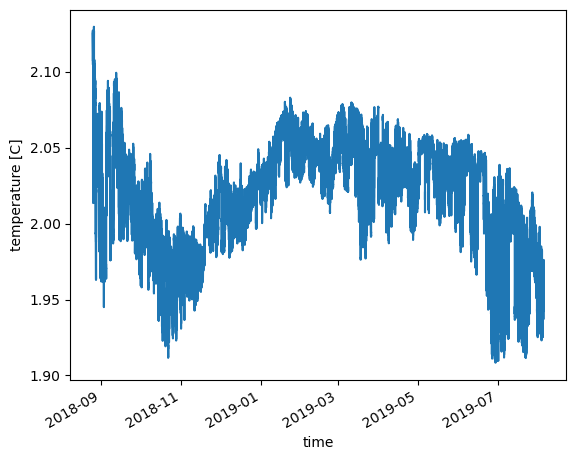

OMG_Narwhals_Mooring_temp_L1_05608533_20180826.nc


<xarray.Dataset>
Dimensions:      (time: 1486080)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-26 ... 2019-08-04T23:59:40
Data variables:
    temperature  (time) float64 2.125 2.125 2.125 2.125 ... 1.961 1.958 1.959
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0980-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 1494437
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608555'>
SBE56 05608555
2018-08-24T00:00:00
before
[236.       236.000231 236.000463 236.000694 236.000926]

after
[numpy.datetime64('2018-08-24T00:00:00'),
 numpy.datetime64('2018-08-24T00:00:20'),
 numpy.datetime64('2018-08-24T00:00:40'),
 numpy.datetime64('2018-08-24T00:01:00'),
 numpy.datetime64('2018-08-24T00:01:20')]
recording start time:  2018-08-24T00:00:00
recording end time:  2019-08-04T22:25:20
data successfully trimmed


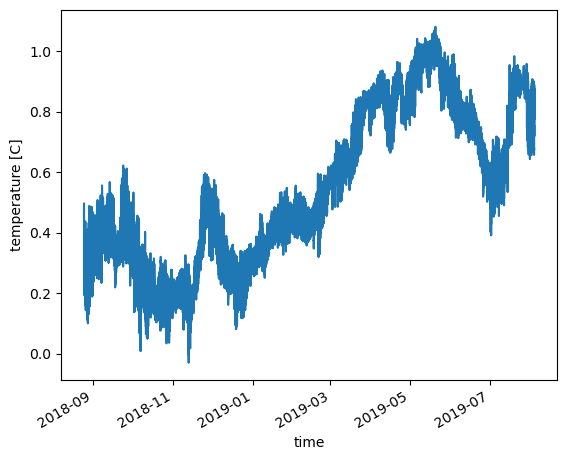

OMG_Narwhals_Mooring_temp_L1_05608555_20180825.nc


<xarray.Dataset>
Dimensions:      (time: 1486080)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-25 ... 2019-08-03T23:59:40
Data variables:
    temperature  (time) float64 0.4532 0.4535 0.4526 ... 0.8224 0.8216 0.8217
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a04f8-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 3613968
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608514'>
SBE56 05608514
2019-08-04T09:00:00
before
[216.375    216.375231 216.375463 216.375694 216.375926]

after
[numpy.datetime64('2019-08-04T09:00:00'),
 numpy.datetime64('2019-08-04T09:00:20'),
 numpy.datetime64('2019-08-04T09:00:40'),
 numpy.datetime64('2019-08-04T09:01:00'),
 numpy.datetime64('2019-08-04T09:01:20')]
recording start time:  2019-08-04T09:00:00
recording end time:  2021-11-17T22:35:40
data successfully trimmed


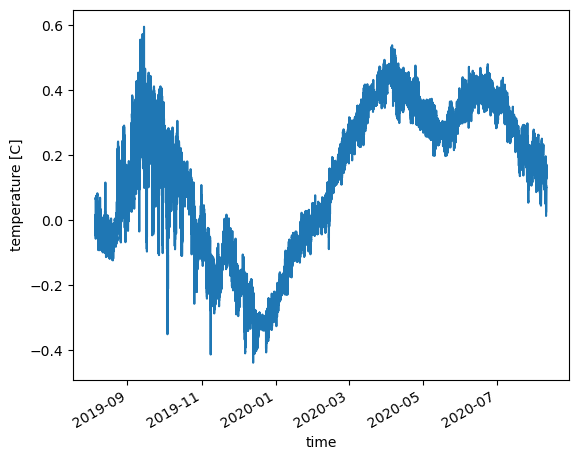

OMG_Narwhals_Mooring_temp_L1_05608514_20190805.nc


<xarray.Dataset>
Dimensions:      (time: 1600920)
Coordinates:
  * time         (time) datetime64[ns] 2019-08-05T20:00:00 ... 2020-08-10T09:...
Data variables:
    temperature  (time) float64 0.0665 0.0681 0.0679 ... 0.1355 0.1354 0.1355
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   37f99886-726d-11ec-90d6-0242ac120003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 3613256
number header lines 88 

* <HardwareData DeviceType='SBE56' SerialNumber='05608516'>
SBE56 05608516
2019-08-04T09:00:00
before
[216.375    216.375231 216.375463 216.375694 216.375926]

after
[numpy.datetime64('2019-08-04T09:00:00'),
 numpy.datetime64('2019-08-04T09:00:20'),
 numpy.datetime64('2019-08-04T09:00:40'),
 numpy.datetime64('2019-08-04T09:01:00'),
 numpy.datetime64('2019-08-04T09:01:20')]
recording start time:  2019-08-04T09:00:00
recording end time:  2021-11-17T18:38:20
data successfully trimmed
data successfully trimmed


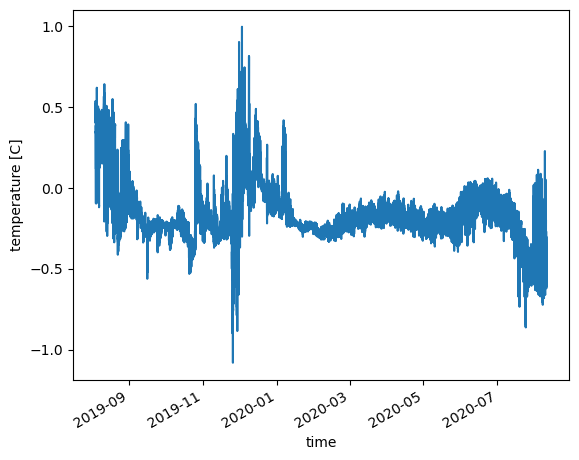

OMG_Narwhals_Mooring_temp_L1_05608516_20190804.nc


<xarray.Dataset>
Dimensions:      (time: 1606320)
Coordinates:
  * time         (time) datetime64[ns] 2019-08-04T14:00:00 ... 2020-08-10T09:...
Data variables:
    temperature  (time) float64 0.5155 0.5141 0.5097 ... -0.5559 -0.557 -0.5556
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   37f98db4-726d-11ec-90d6-0242ac120003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 3613416
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608517'>
SBE56 05608517
2019-08-05T09:00:00
before
[217.375    217.375231 217.375463 217.375694 217.375926]

after
[numpy.datetime64('2019-08-05T09:00:00'),
 numpy.datetime64('2019-08-05T09:00:20'),
 numpy.datetime64('2019-08-05T09:00:40'),
 numpy.datetime64('2019-08-05T09:01:00'),
 numpy.datetime64('2019-08-05T09:01:20')]
recording start time:  2019-08-05T09:00:00
recording end time:  2021-11-18T19:31:40
data successfully trimmed


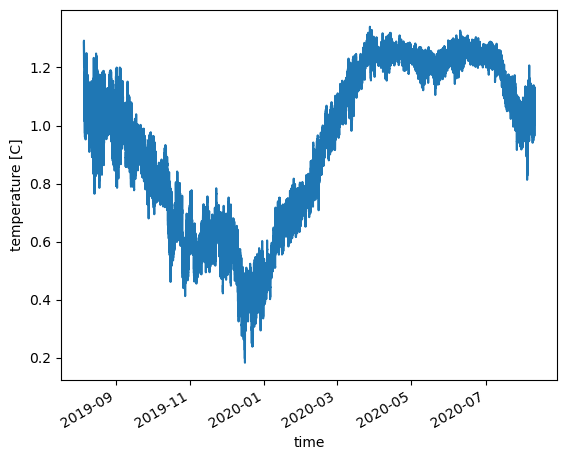

OMG_Narwhals_Mooring_temp_L1_05608517_20190805.nc


<xarray.Dataset>
Dimensions:      (time: 1600920)
Coordinates:
  * time         (time) datetime64[ns] 2019-08-05T20:00:00 ... 2020-08-10T09:...
Data variables:
    temperature  (time) float64 1.286 1.282 1.282 1.282 ... 1.092 1.092 1.093
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   37f9a010-726d-11ec-90d6-0242ac120003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 3613868
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608518'>
SBE56 05608518
2019-08-04T09:00:00
before
[216.375    216.375231 216.375463 216.375694 216.375926]

after
[numpy.datetime64('2019-08-04T09:00:00'),
 numpy.datetime64('2019-08-04T09:00:20'),
 numpy.datetime64('2019-08-04T09:00:40'),
 numpy.datetime64('2019-08-04T09:01:00'),
 numpy.datetime64('2019-08-04T09:01:20')]
recording start time:  2019-08-04T09:00:00
recording end time:  2021-11-17T22:02:20
data successfully trimmed
data successfully trimmed


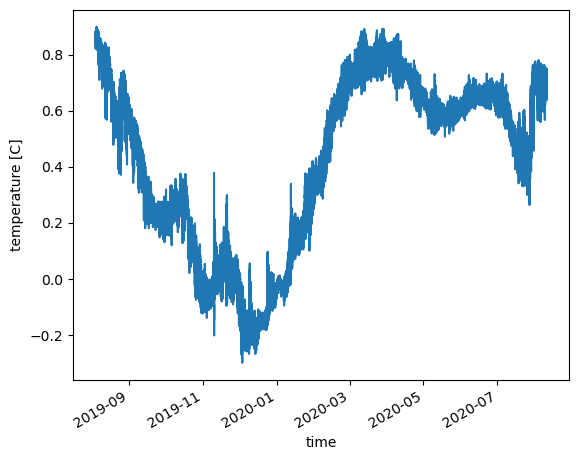

OMG_Narwhals_Mooring_temp_L1_05608518_20190804.nc


<xarray.Dataset>
Dimensions:      (time: 1606320)
Coordinates:
  * time         (time) datetime64[ns] 2019-08-04T14:00:00 ... 2020-08-10T09:...
Data variables:
    temperature  (time) float64 0.8413 0.8361 0.8355 ... 0.6685 0.6647 0.6746
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   37f9976e-726d-11ec-90d6-0242ac120003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 3613524
number header lines 88 

* <HardwareData DeviceType='SBE56' SerialNumber='05608519'>
SBE56 05608519
2019-08-05T09:00:00
before
[217.375    217.375231 217.375463 217.375694 217.375926]

after
[numpy.datetime64('2019-08-05T09:00:00'),
 numpy.datetime64('2019-08-05T09:00:20'),
 numpy.datetime64('2019-08-05T09:00:40'),
 numpy.datetime64('2019-08-05T09:01:00'),
 numpy.datetime64('2019-08-05T09:01:20')]
recording start time:  2019-08-05T09:00:00
recording end time:  2021-11-18T20:07:40
data successfully trimmed


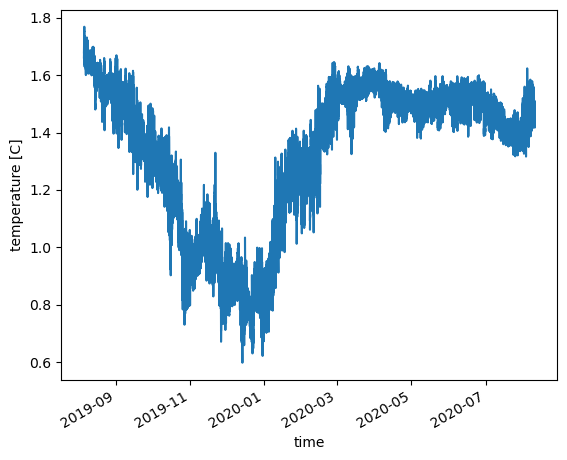

OMG_Narwhals_Mooring_temp_L1_05608519_20190805.nc


<xarray.Dataset>
Dimensions:      (time: 1600920)
Coordinates:
  * time         (time) datetime64[ns] 2019-08-05T20:00:00 ... 2020-08-10T09:...
Data variables:
    temperature  (time) float64 1.679 1.679 1.678 1.678 ... 1.444 1.444 1.444
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   37f9a236-726d-11ec-90d6-0242ac120003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 3613638
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608520'>
SBE56 05608520
2019-08-04T09:00:00
before
[216.375    216.375231 216.375463 216.375694 216.375926]

after
[numpy.datetime64('2019-08-04T09:00:00'),
 numpy.datetime64('2019-08-04T09:00:20'),
 numpy.datetime64('2019-08-04T09:00:40'),
 numpy.datetime64('2019-08-04T09:01:00'),
 numpy.datetime64('2019-08-04T09:01:20')]
recording start time:  2019-08-04T09:00:00
recording end time:  2021-11-17T20:45:40
data successfully trimmed
data successfully trimmed


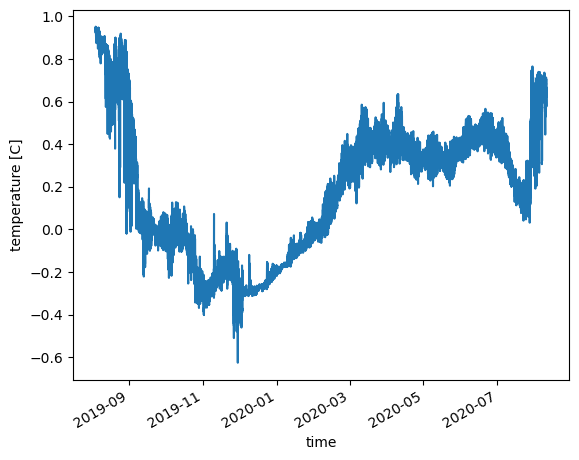

OMG_Narwhals_Mooring_temp_L1_05608520_20190804.nc


<xarray.Dataset>
Dimensions:      (time: 1606320)
Coordinates:
  * time         (time) datetime64[ns] 2019-08-04T14:00:00 ... 2020-08-10T09:...
Data variables:
    temperature  (time) float64 0.9432 0.9429 0.943 ... 0.6431 0.643 0.6431
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   37f99534-726d-11ec-90d6-0242ac120003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 3613584
number header lines 88 

* <HardwareData DeviceType='SBE56' SerialNumber='05608523'>
SBE56 05608523
2019-08-04T09:00:00
before
[216.375    216.375231 216.375463 216.375694 216.375926]

after
[numpy.datetime64('2019-08-04T09:00:00'),
 numpy.datetime64('2019-08-04T09:00:20'),
 numpy.datetime64('2019-08-04T09:00:40'),
 numpy.datetime64('2019-08-04T09:01:00'),
 numpy.datetime64('2019-08-04T09:01:20')]
recording start time:  2019-08-04T09:00:00
recording end time:  2021-11-17T20:27:40
data successfully trimmed
data successfully trimmed


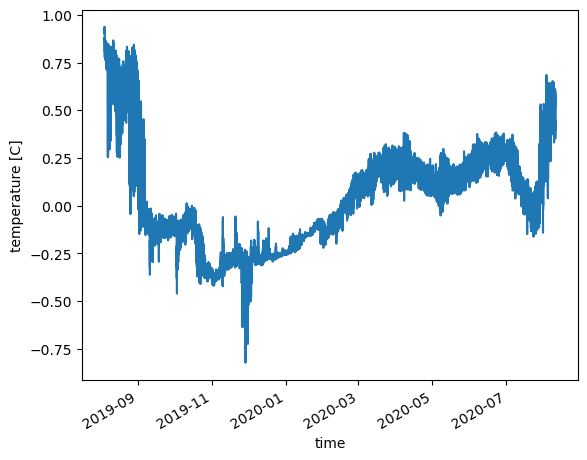

OMG_Narwhals_Mooring_temp_L1_05608523_20190804.nc


<xarray.Dataset>
Dimensions:      (time: 1606320)
Coordinates:
  * time         (time) datetime64[ns] 2019-08-04T14:00:00 ... 2020-08-10T09:...
Data variables:
    temperature  (time) float64 0.9195 0.9184 0.9183 ... 0.3985 0.3974 0.3958
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   37f993e0-726d-11ec-90d6-0242ac120003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 3609252
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608524'>
SBE56 05608524
2019-08-06T09:00:00
before
[218.375    218.375231 218.375463 218.375694 218.375926]

after
[numpy.datetime64('2019-08-06T09:00:00'),
 numpy.datetime64('2019-08-06T09:00:20'),
 numpy.datetime64('2019-08-06T09:00:40'),
 numpy.datetime64('2019-08-06T09:01:00'),
 numpy.datetime64('2019-08-06T09:01:20')]
recording start time:  2019-08-06T09:00:00
recording end time:  2021-11-18T20:23:40
data successfully trimmed


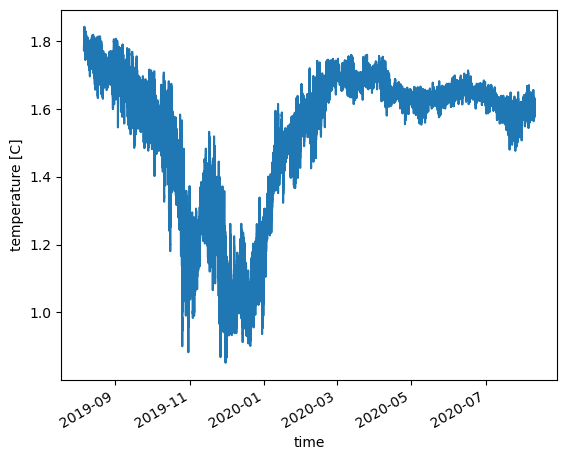

OMG_Narwhals_Mooring_temp_L1_05608524_20190806.nc


<xarray.Dataset>
Dimensions:      (time: 1598580)
Coordinates:
  * time         (time) datetime64[ns] 2019-08-06T09:00:00 ... 2020-08-10T09:...
Data variables:
    temperature  (time) float64 1.781 1.781 1.78 1.779 ... 1.596 1.597 1.597
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   37f9a34e-726d-11ec-90d6-0242ac120003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 3613690
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608525'>
SBE56 05608525
2019-08-04T09:00:00
before
[216.375    216.375231 216.375463 216.375694 216.375926]

after
[numpy.datetime64('2019-08-04T09:00:00'),
 numpy.datetime64('2019-08-04T09:00:20'),
 numpy.datetime64('2019-08-04T09:00:40'),
 numpy.datetime64('2019-08-04T09:01:00'),
 numpy.datetime64('2019-08-04T09:01:20')]
recording start time:  2019-08-04T09:00:00
recording end time:  2021-11-17T21:03:00
data successfully trimmed
data successfully trimmed


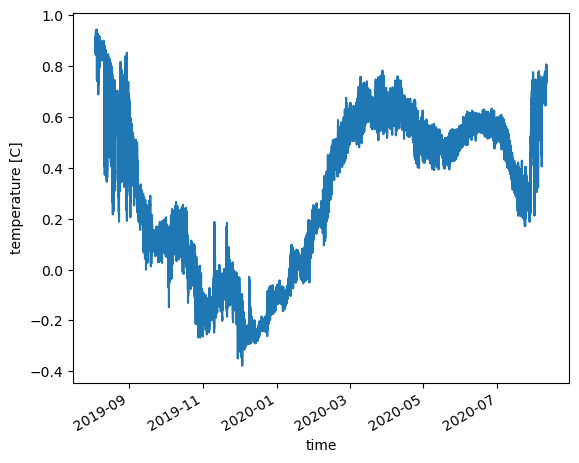

OMG_Narwhals_Mooring_temp_L1_05608525_20190804.nc


<xarray.Dataset>
Dimensions:      (time: 1606320)
Coordinates:
  * time         (time) datetime64[ns] 2019-08-04T14:00:00 ... 2020-08-10T09:...
Data variables:
    temperature  (time) float64 0.9131 0.9129 0.914 ... 0.7725 0.7723 0.7722
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   37f99656-726d-11ec-90d6-0242ac120003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 3613359
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608526'>
SBE56 05608526
2019-08-05T08:59:59
before
[217.374988 217.37522  217.375451 217.375683 217.375914]

after
[numpy.datetime64('2019-08-05T08:59:59'),
 numpy.datetime64('2019-08-05T09:00:19'),
 numpy.datetime64('2019-08-05T09:00:39'),
 numpy.datetime64('2019-08-05T09:00:59'),
 numpy.datetime64('2019-08-05T09:01:19')]
recording start time:  2019-08-05T08:59:59
recording end time:  2021-11-18T19:12:39
data successfully trimmed


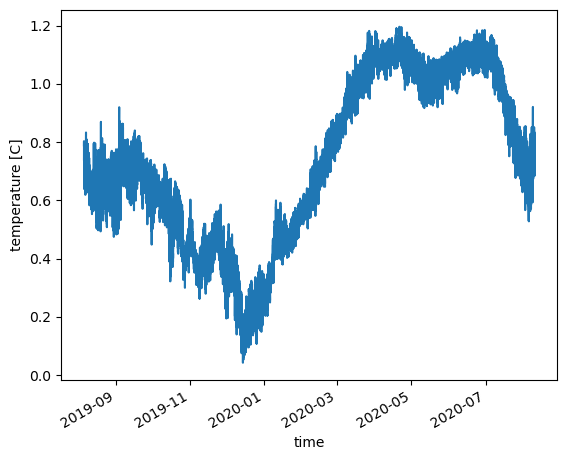

OMG_Narwhals_Mooring_temp_L1_05608526_20190805.nc


<xarray.Dataset>
Dimensions:      (time: 1600920)
Coordinates:
  * time         (time) datetime64[ns] 2019-08-05T20:00:19 ... 2020-08-10T09:...
Data variables:
    temperature  (time) float64 0.789 0.7895 0.7914 ... 0.7323 0.7318 0.7306
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   37f99eee-726d-11ec-90d6-0242ac120003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 3613522
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608529'>
SBE56 05608529
2019-08-04T09:00:00
before
[216.375    216.375231 216.375463 216.375694 216.375926]

after
[numpy.datetime64('2019-08-04T09:00:00'),
 numpy.datetime64('2019-08-04T09:00:20'),
 numpy.datetime64('2019-08-04T09:00:40'),
 numpy.datetime64('2019-08-04T09:01:00'),
 numpy.datetime64('2019-08-04T09:01:20')]
recording start time:  2019-08-04T09:00:00
recording end time:  2021-11-17T20:07:00
data successfully trimmed
data successfully trimmed


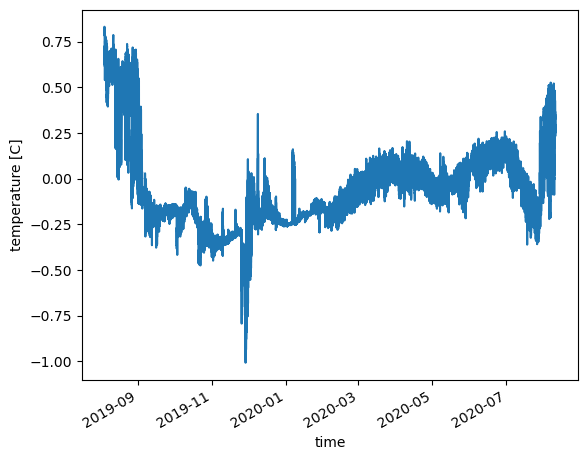

OMG_Narwhals_Mooring_temp_L1_05608529_20190804.nc


<xarray.Dataset>
Dimensions:      (time: 1606320)
Coordinates:
  * time         (time) datetime64[ns] 2019-08-04T14:00:00 ... 2020-08-10T09:...
Data variables:
    temperature  (time) float64 0.8168 0.8167 0.8179 ... 0.2926 0.2926 0.2926
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   37f98ecc-726d-11ec-90d6-0242ac120003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 3613240
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608530'>
SBE56 05608530
2019-08-05T09:00:00
before
[217.375    217.375231 217.375463 217.375694 217.375926]

after
[numpy.datetime64('2019-08-05T09:00:00'),
 numpy.datetime64('2019-08-05T09:00:20'),
 numpy.datetime64('2019-08-05T09:00:40'),
 numpy.datetime64('2019-08-05T09:01:00'),
 numpy.datetime64('2019-08-05T09:01:20')]
recording start time:  2019-08-05T09:00:00
recording end time:  2021-11-18T18:33:00
data successfully trimmed


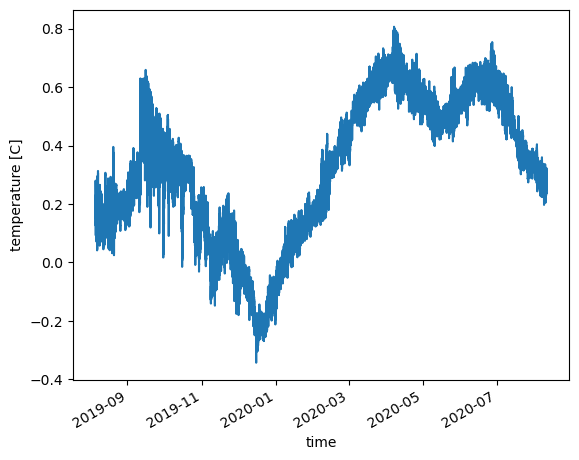

OMG_Narwhals_Mooring_temp_L1_05608530_20190805.nc


<xarray.Dataset>
Dimensions:      (time: 1600920)
Coordinates:
  * time         (time) datetime64[ns] 2019-08-05T20:00:00 ... 2020-08-10T09:...
Data variables:
    temperature  (time) float64 0.2279 0.2169 0.2183 ... 0.2879 0.2892 0.2906
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   37f9999e-726d-11ec-90d6-0242ac120003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 3613294
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608532'>
SBE56 05608532
2019-08-05T09:00:00
before
[217.375    217.375231 217.375463 217.375694 217.375926]

after
[numpy.datetime64('2019-08-05T09:00:00'),
 numpy.datetime64('2019-08-05T09:00:20'),
 numpy.datetime64('2019-08-05T09:00:40'),
 numpy.datetime64('2019-08-05T09:01:00'),
 numpy.datetime64('2019-08-05T09:01:20')]
recording start time:  2019-08-05T09:00:00
recording end time:  2021-11-18T18:51:00
data successfully trimmed


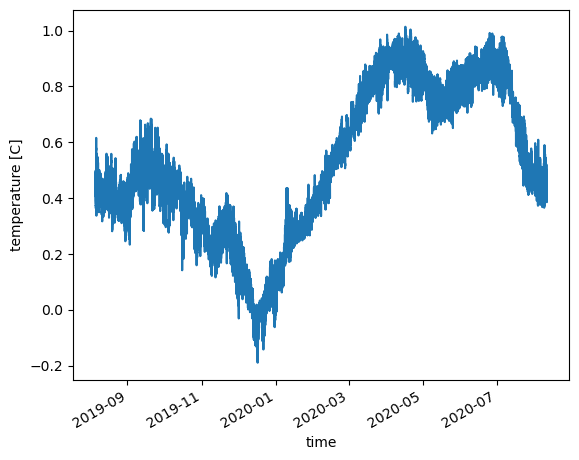

OMG_Narwhals_Mooring_temp_L1_05608532_20190805.nc


<xarray.Dataset>
Dimensions:      (time: 1600920)
Coordinates:
  * time         (time) datetime64[ns] 2019-08-05T20:00:00 ... 2020-08-10T09:...
Data variables:
    temperature  (time) float64 0.4646 0.4443 0.4607 ... 0.3897 0.388 0.3858
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   37f99ab6-726d-11ec-90d6-0242ac120003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

number data lines 3613465
number header lines 86 

* <HardwareData DeviceType='SBE56' SerialNumber='05608555'>
SBE56 05608555
2019-08-05T09:00:00
before
[217.375    217.375231 217.375463 217.375694 217.375926]

after
[numpy.datetime64('2019-08-05T09:00:00'),
 numpy.datetime64('2019-08-05T09:00:20'),
 numpy.datetime64('2019-08-05T09:00:40'),
 numpy.datetime64('2019-08-05T09:01:00'),
 numpy.datetime64('2019-08-05T09:01:20')]
recording start time:  2019-08-05T09:00:00
recording end time:  2021-11-18T19:48:00
data successfully trimmed


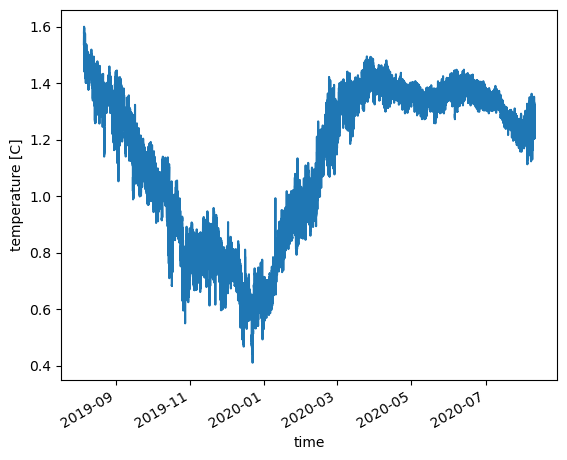

OMG_Narwhals_Mooring_temp_L1_05608555_20190805.nc


<xarray.Dataset>
Dimensions:      (time: 1600920)
Coordinates:
  * time         (time) datetime64[ns] 2019-08-05T20:00:00 ... 2020-08-10T09:...
Data variables:
    temperature  (time) float64 1.579 1.581 1.582 1.581 ... 1.25 1.249 1.249
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   37f9a128-726d-11ec-90d6-0242ac120003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

In [4]:
## create a loop that uses the above functions for all mooring data files
## loop through cnvfiles object

for year in years:
    if year == 2019:
        os.chdir("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L0/2019/SBE56")
        metadata_path = Path("/Users/marie/Documents/PhD/Chapter_3/OMG_Python_dir/metadata/2019/SBE56_metadata_2019.csv")
        # output directory
        output_dir = Path('/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L1/2019/SBE56/')
    if year == 2020:
        os.chdir("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L0/2020/SBE56")
        metadata_path = Path("/Users/marie/Documents/PhD/Chapter_3/OMG_Python_dir/metadata/2020/SBE56_metadata_2020.csv")
        output_dir = Path('/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L1/2020/SBE56/')
        
    cnvfiles = []
    for file in glob.glob("*.cnv"):
        cnvfiles.append(file)
    # pprint(cnvfiles)
    
    ## get all metadata associated with each data file
    # read in csv with metadata
    metadata = pd.read_csv(metadata_path)

    for filename in cnvfiles:
        # extract metadata
        data = metadata.loc[metadata['filename_L0'] == filename] # select row for cnv file 'filename'
        glacier_front = data.glacier_front.values[0]
        probe_num = data.probe_num.values[0]
        lat = data.lat.values[0]
        lon = data.lon.values[0]
        bottom_depth = data.bottom_depth.values[0]
        
        if year == 2019:
            file = Path("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L0/2019/SBE56/" + filename) # 2019
        if year == 2020:
            file = Path("/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L0/2020/SBE56/" + filename) # 2020
    
        uuid = data.uuid.values[0]
        depth_target = data.depth_target.values[0]
        depth_actual = data.depth_actual.values[0]

        ## extract data and create dataset
        data_lines, device_type, serial_number, start_time_dt64, start_date, sample_interval_plain, sample_interval_td64, var_names = omg56_funs.open_omg_file(file)
        mooring_ds = omg56_funs.create_Dataset(data_lines, start_time_dt64, sample_interval_td64, glacier_front, probe_num)
        
        ## Create NetCDF variable encoding (required to save the time values properly)
        new_encoding = omg56_funs.create_encoding(mooring_ds)
        
        ## Save xarray DataSet object as netcdf
        # truncate the last measurement times since those are on the deck
        # if else statement to truncate data according to each fjord
        if year == 2019:
            if glacier_front=='Sverdrup glacier':
                mooring_ds_truncated = mooring_ds.sel(time=slice("2018-08-24","2019-08-02")) 
                print('data successfully trimmed')
            elif glacier_front=='Kong Oscar glacier':
                mooring_ds_truncated = mooring_ds.sel(time=slice("2018-08-25","2019-08-03"))
                print('data successfully trimmed')
            elif probe_num == 'PROBE_14':
                mooring_ds_truncated = mooring_ds.sel(time=slice("2018-08-26","2019-07-10"))
                print('data successfully trimmed')
            else: 
                mooring_ds_truncated = mooring_ds.sel(time=slice("2018-08-26","2019-08-04"))
                print('data successfully trimmed')
        if year == 2020:
            if glacier_front=='Kong Oscar glacier':
                mooring_ds_truncated = mooring_ds.sel(time=slice("2019-08-04T14","2020-08-10T09")) 
                print('data successfully trimmed')
            else: mooring_ds_truncated = mooring_ds.sel(time=slice("2019-08-05T20","2020-08-10T09"))
            print('data successfully trimmed')
            
        # plot trimmed data
        mooring_ds_truncated.temperature.plot()
        plt.show()
        
        # create netcdf filename:
        # “OMG_Narwhals_Mooring_<instrument>_L1_<time_coverage_start>.nc"
        date_str = str(mooring_ds_truncated.isel(time=0).time.values)
        yymmdd = date_str[0:4] + date_str[5:7] + date_str[8:10]
        netcdf_filename = 'OMG_Narwhals_Mooring_temp_L1_' + serial_number + '_' + yymmdd + '.nc'
        print(netcdf_filename)
        
        # add metadata
        mooring_ds_final = omg56_funs.add_metadata(mooring_ds_truncated, uuid, lat, lon, glacier_front, bottom_depth, depth_target,\
                                                   depth_actual, netcdf_filename, start_date, sample_interval_plain, serial_number, device_type, probe_num)
        
        # print dataset
        with xr.set_options(display_style="html"):
            display(mooring_ds_final)
            
        # export file
        netcdf_filename = Path(netcdf_filename)
        mooring_ds_final.to_netcdf(output_dir / netcdf_filename, encoding=new_encoding)
        mooring_ds_final.close()

## Check a file

In [5]:
netcdf_filename = 'OMG_Narwhals_Mooring_temp_L1_05608513_20180826.nc'
output_dir = Path('/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L1/2019/SBE56/')

In [6]:
tmp = xr.open_dataset(output_dir / netcdf_filename)
tmp.close()

In [7]:
tmp

<xarray.Dataset>
Dimensions:      (time: 1486080)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-26 ... 2019-08-04T23:59:40
Data variables:
    temperature  (time) float64 ...
Attributes: (12/43)
    title:                  OMG Narwhals mooring temperature logger Level 1 Data
    summary:                This dataset contains temperature measurements fr...
    keywords:               Water Temperature
    keywords_vocabulary:    NASA Global Change Master Directory (GCMD) Scienc...
    id:                     OMG_Narwhals_Mooring_temp_L1
    uuid:                   906a0d18-14dd-11ec-82a8-0242ac130003
    ...                     ...
    contributor_role:       OMG Narwhals Science Team performed mooring deplo...
    publisher_name:         Physical Oceanography Distributed Active Archive ...
    publisher_institution:  PO.DAAC
    publisher_email:        podaac@podaac.jpl.nasa.gov
    publisher_url:          https://podaac.jpl.nasa.gov/
    publisher_type:         group

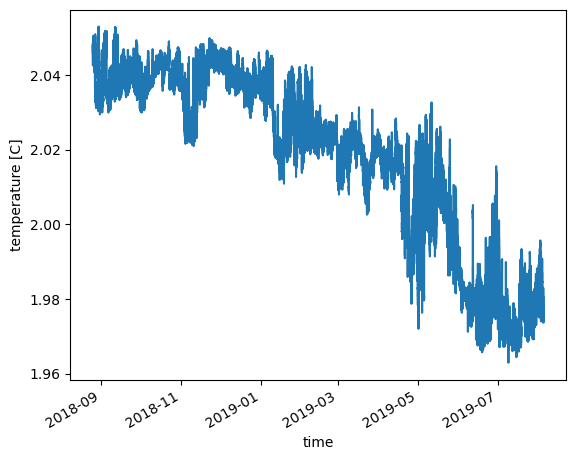

In [8]:
tmp.temperature.plot()